# ML Analysis

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict

In [2]:
ML_results = 'ML/krr_metrics.json'

In [3]:
with open(ML_results, "r") as f:
    results = json.load(f)

print(results)

{'50': {'cmbdf_global': {'krr': {'0': {'ksd': 0.22826566042808472, 'kpd': 0.3184463114494215, 'kp': 0.2476333354697758, 'ks': 0.09268183067436218, 'kexp': 0.1948896290764455, 'max_atomic_forces': 0.032487380846483595, 'max_atomic_forces_label': 0.008945116358131121}, '1': {'ksd': 0.25726378363690605, 'kpd': 0.27438827060590776, 'kp': 0.26384762967364506, 'ks': 0.10241530027236082, 'kexp': 0.14860163883226332, 'max_atomic_forces': 0.029691680079081212, 'max_atomic_forces_label': 0.008877326417777562}, '2': {'ksd': 0.24229962990909873, 'kpd': 0.2809248750347754, 'kp': 0.3033644153195383, 'ks': 0.10987793290718367, 'kexp': 0.19754278370076583, 'max_atomic_forces': 0.03383536725732185, 'max_atomic_forces_label': 0.009409015955290511}, '3': {'ksd': 0.21781444229065589, 'kpd': 0.2806904184724707, 'kp': 0.2756886698322305, 'ks': 0.09648779936380902, 'kexp': 0.14957899278935163, 'max_atomic_forces': 0.031096763232285142, 'max_atomic_forces_label': 0.009766104039976157}, '4': {'ksd': 0.22587559

In [4]:
nested_dict = lambda: defaultdict(nested_dict)
results_summary = nested_dict()

for train_set_size in results.keys():
    for rep in results[train_set_size].keys():
        for model in results[train_set_size][rep].keys():
            fold_scores = pd.DataFrame(results[train_set_size][rep][model]).T

            results_summary[rep][model][train_set_size] = fold_scores.mean(axis=0)

results_summary

defaultdict(<function __main__.<lambda>()>,
            {'cmbdf_global': defaultdict(<function __main__.<lambda>()>,
                         {'krr': defaultdict(<function __main__.<lambda>()>,
                                      {'50': ksd                        0.234304
                                       kpd                        0.287033
                                       kp                         0.267327
                                       ks                         0.098636
                                       kexp                       0.167919
                                       max_atomic_forces          0.030098
                                       max_atomic_forces_label    0.009167
                                       dtype: float64,
                                       '100': ksd                        0.204607
                                       kpd                        0.249196
                                       kp                      

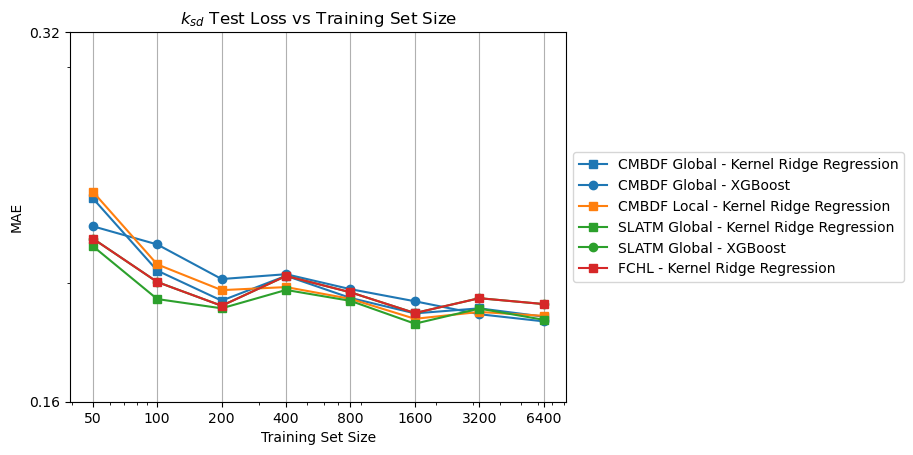

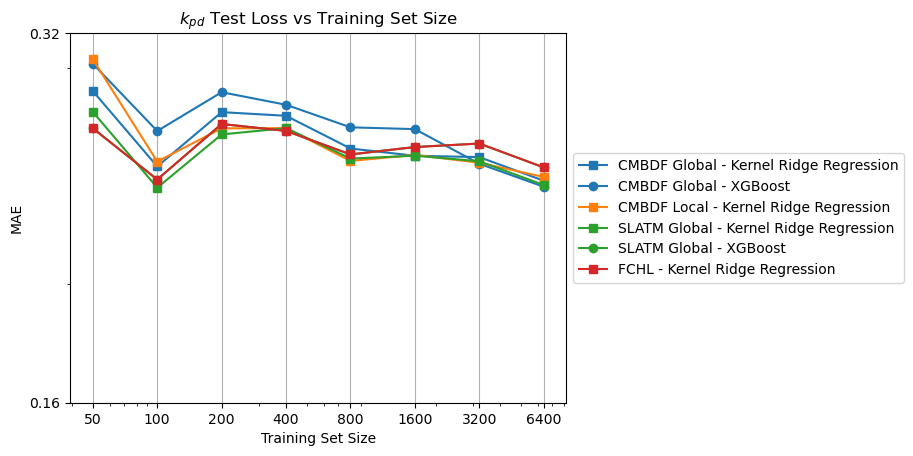

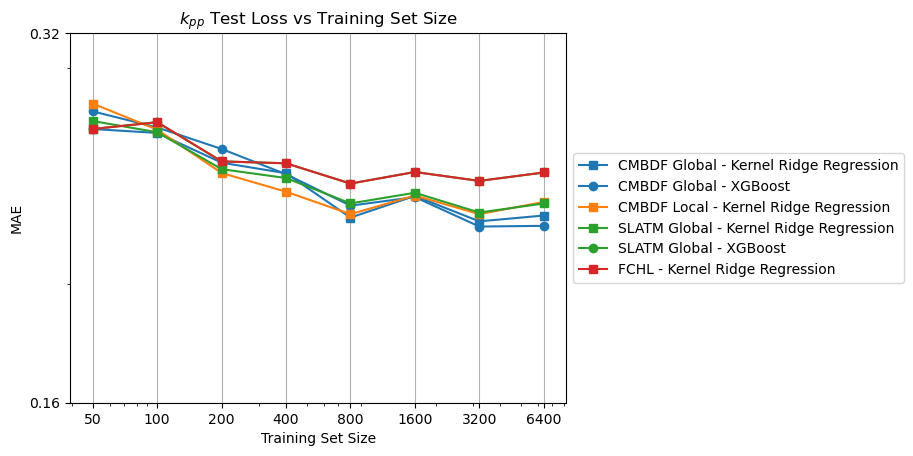

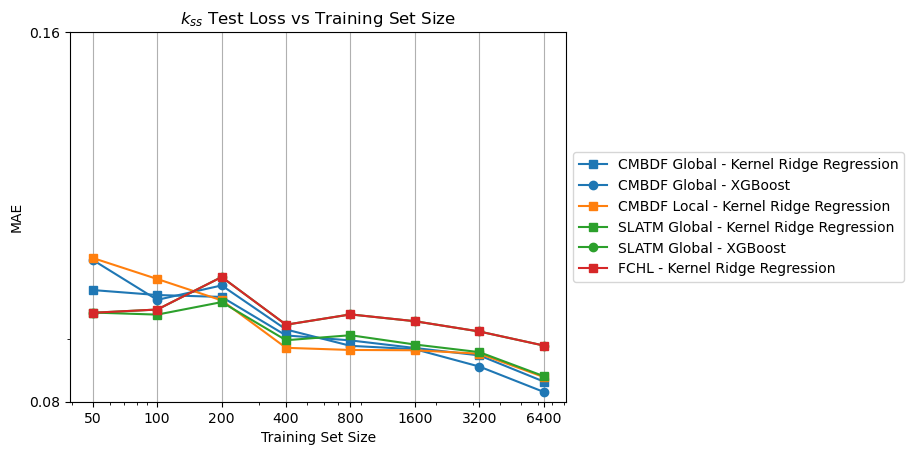

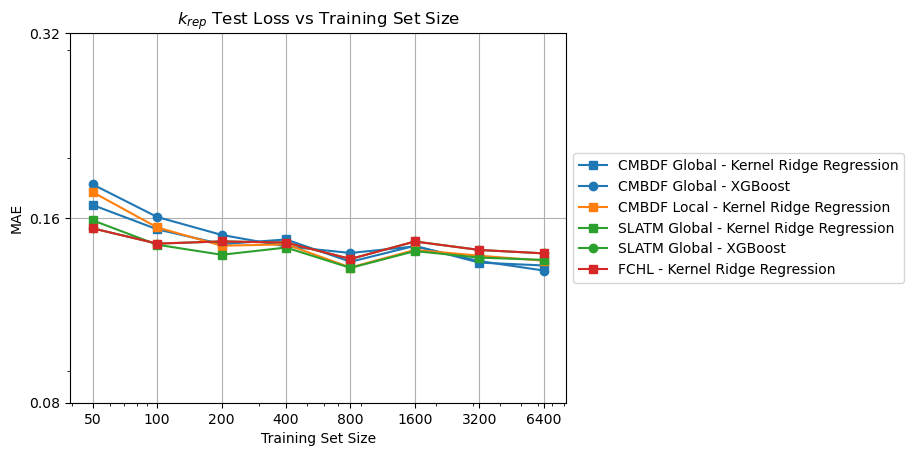

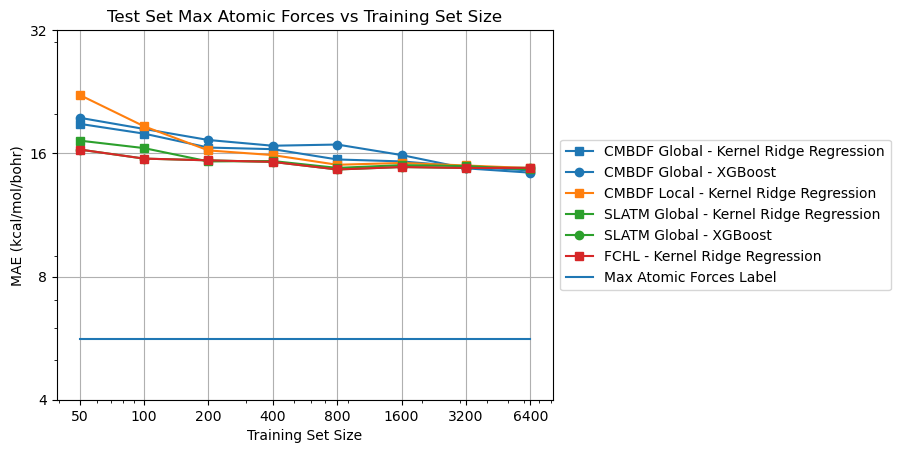

In [5]:
HARTREES_TO_KCAL_MOL = 627.5095

figures = {
    "ksd": plt.figure(),
    "kpd": plt.figure(),
    "kp": plt.figure(),
    "ks": plt.figure(),
    "kexp": plt.figure(),
    "max_atomic_forces": plt.figure(),
}

figures["max_atomic_forces_label"] = figures["max_atomic_forces"]

labels = {
    'cmbdf_global': "CMBDF Global",
    'cmbdf_local': "CMBDF Local",
    'slatm_global': "SLATM Global",
    'fchl': "FCHL",
    'xgboost': "XGBoost",
    'krr': "Kernel Ridge Regression",
    'ksd': r'$k_{sd}$',
    'kpd': r'$k_{pd}$',
    'kp': r'$k_{pp}$',
    'ks': r'$k_{ss}$',
    'kexp': r'$k_{rep}$',
    'max_atomic_forces': 'Max Atomic Forces',
    'max_atomic_forces_label': 'Max Atomic Forces',
}

markers = {
    "xgboost": "o",
    "krr": "s",
}

colors = {
    "cmbdf_global": "tab:blue",
    "cmbdf_local": "tab:orange",
    "slatm_global": "tab:green",
    "fchl": "tab:red",
}

ylims = {
    "ksd": (0.16, 0.32),
    "kpd": (0.16, 0.32),
    "kp": (0.16, 0.32),
    "ks": (0.08, 0.16),
    "kexp": (0.08, 0.32),
    "max_atomic_forces": (4, 32),

}
ylims["max_atomic_forces_label"] = ylims["max_atomic_forces"]

labelled = False

for metric, fig in figures.items():
    ax = fig.gca()
    for rep in results_summary.keys():
        for model in results_summary[rep].keys():
            results_df = pd.DataFrame(results_summary[rep][model]).T
            results_df = results_df.loc[:, results_df.columns == metric]
            results_df.index = results_df.index.astype(int)

            if 'max_atomic_forces' in metric:
                results_df[metric] = results_df[metric] * HARTREES_TO_KCAL_MOL

            if metric == "max_atomic_forces_label":
                if labelled:
                    continue
                else:
                    results_df[metric] = results_df[metric].min()

                    ax.plot(
                        results_df.index,
                        results_df[metric],
                        label=f"Max Atomic Forces Label",
                    )
                    labelled = True
                    continue

            else:
                ax.plot(
                    results_df.index,
                    results_df[metric],
                    label=f"{labels[rep]} - {labels[model]}",
                    marker=markers[model],
                    color=colors[rep],
                )
    
    if metric == 'max_atomic_forces':
        continue

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())

    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())

    xticks = [50, 100, 200, 400, 800, 1600, 3200, 6400]

    cur_ylims = ylims[metric]
    yticks = [cur_ylims[0]]
    while yticks[-1] < cur_ylims[1]:
        yticks.append(yticks[-1] * 2)

    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    ax.set_xlabel("Training Set Size")

    if metric == 'max_atomic_forces_label':
        ax.set_ylabel('MAE (kcal/mol/bohr)')
        ax.set_title(f"Test Set {labels[metric]} vs Training Set Size")
    else:
        ax.set_ylabel('MAE')
        ax.set_title(f"{labels[metric]} Test Loss vs Training Set Size")
    ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    ax.grid(True)

    # save as svg
    fig.savefig(f"ML/{metric}_test_loss_vs_train_set_size.svg", bbox_inches='tight')